## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Import XGBoost
try:
    from xgboost import XGBRegressor
    print("✅ XGBoost berhasil diimport!")
except ImportError:
    print("⚠️ XGBoost belum terinstall, menginstall...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    from xgboost import XGBRegressor
    print("✅ XGBoost berhasil diinstall dan diimport!")

print("✅ Semua library berhasil diimport!")

⚠️ XGBoost belum terinstall, menginstall...
✅ XGBoost berhasil diinstall dan diimport!
✅ Semua library berhasil diimport!


## 2. Load Data Residual dari Soal 4

In [2]:
# Load data residual
df_residuals = pd.read_csv('DATA/all_residuals_clean.csv', index_col='TANGGAL', parse_dates=True)

print("="*60)
print("DATA RESIDUAL DARI SOAL 4")
print("="*60)
print(f"Jumlah data: {len(df_residuals)} hari")
print(f"Periode: {df_residuals.index.min().strftime('%d-%m-%Y')} s.d. {df_residuals.index.max().strftime('%d-%m-%Y')}")
print(f"\nKolom yang tersedia: {list(df_residuals.columns)}")

# Hanya gunakan TAVG dan RR sesuai instruksi
columns_to_use = ['TAVG_residual', 'RR_residual']
print(f"\n📌 Parameter yang digunakan untuk Soal 5: TAVG dan RR")

print("\nPreview data:")
df_residuals[columns_to_use].head(10)

DATA RESIDUAL DARI SOAL 4
Jumlah data: 333 hari
Periode: 19-01-2024 s.d. 16-12-2024

Kolom yang tersedia: ['TAVG_residual', 'RH_AVG_residual', 'RR_residual', 'FF_AVG_residual']

📌 Parameter yang digunakan untuk Soal 5: TAVG dan RR

Preview data:


,TAVG_residual,RR_residual
TANGGAL,,
2024-01-19,-1.640169,4.702069
2024-01-20,-0.018502,-2.959841
2024-01-21,0.050664,-5.961746
2024-01-22,0.184610,5.005366
2024-01-23,-0.067208,-6.124226
2024-01-24,-0.402360,-4.091799
2024-01-25,1.412034,-0.689600
2024-01-26,0.607489,-12.737240
2024-01-27,0.692034,-3.279970


## 3. Fungsi untuk Anomaly Detection

In [3]:
def create_features(data, window_size=5):
    """
    Membuat fitur untuk model regressor dari data time series.
    Menggunakan lag features dan rolling statistics.
    """
    df = pd.DataFrame(index=data.index)
    df['target'] = data.values
    
    # Lag features
    for i in range(1, window_size + 1):
        df[f'lag_{i}'] = data.shift(i)
    
    # Rolling statistics
    df['rolling_mean'] = data.rolling(window=window_size).mean()
    df['rolling_std'] = data.rolling(window=window_size).std()
    
    # Drop NaN
    df = df.dropna()
    
    return df


def detect_anomalies_with_regressor(data, model, model_name, param_name, sigma=3):
    """
    Deteksi anomali menggunakan regressor.
    Anomali dideteksi ketika prediction error > sigma * std(error)
    """
    # Create features
    df_features = create_features(data)
    
    # Separate features and target
    X = df_features.drop('target', axis=1)
    y = df_features['target']
    
    # Train model on all data (untuk anomaly detection)
    model.fit(X, y)
    
    # Predict
    y_pred = model.predict(X)
    
    # Calculate prediction error (residual dari model)
    prediction_error = y - y_pred
    
    # Calculate threshold (3 sigma)
    error_mean = prediction_error.mean()
    error_std = prediction_error.std()
    upper_threshold = error_mean + sigma * error_std
    lower_threshold = error_mean - sigma * error_std
    
    # Detect anomalies
    anomalies = (prediction_error > upper_threshold) | (prediction_error < lower_threshold)
    
    # Create result DataFrame
    results = pd.DataFrame({
        'actual': y,
        'predicted': y_pred,
        'error': prediction_error,
        'is_anomaly': anomalies
    }, index=df_features.index)
    
    # Statistics
    n_anomalies = anomalies.sum()
    anomaly_rate = n_anomalies / len(anomalies) * 100
    
    print(f"\n{'='*60}")
    print(f"{model_name} - {param_name}")
    print(f"{'='*60}")
    print(f"   • Total data points: {len(y)}")
    print(f"   • Threshold: ±{sigma}σ ({lower_threshold:.4f}, {upper_threshold:.4f})")
    print(f"   • Error Mean: {error_mean:.6f}")
    print(f"   • Error Std: {error_std:.6f}")
    print(f"   • Anomalies detected: {n_anomalies} ({anomaly_rate:.2f}%)")
    print(f"   • MAE: {mean_absolute_error(y, y_pred):.4f}")
    print(f"   • RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.4f}")
    
    return results, {
        'model_name': model_name,
        'param': param_name,
        'n_anomalies': n_anomalies,
        'anomaly_rate': anomaly_rate,
        'upper_threshold': upper_threshold,
        'lower_threshold': lower_threshold,
        'error_mean': error_mean,
        'error_std': error_std,
        'mae': mean_absolute_error(y, y_pred),
        'rmse': np.sqrt(mean_squared_error(y, y_pred))
    }

print("✅ Fungsi anomaly detection berhasil dibuat!")

✅ Fungsi anomaly detection berhasil dibuat!


## 4. Fungsi untuk Plot Anomaly Detection

In [4]:
def plot_anomaly_detection(results, stats, param_label, color, save_path=None):
    """
    Plot hasil anomaly detection.
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    model_name = stats['model_name']
    
    # Plot 1: Time Series dengan Anomali
    ax1 = axes[0]
    
    # Plot actual values
    ax1.plot(results.index, results['actual'], color=color, alpha=0.7, 
             linewidth=1, label='Actual Residual')
    
    # Plot predicted values
    ax1.plot(results.index, results['predicted'], color='green', alpha=0.5, 
             linewidth=1, linestyle='--', label='Predicted')
    
    # Highlight anomalies
    anomaly_idx = results[results['is_anomaly']].index
    ax1.scatter(anomaly_idx, results.loc[anomaly_idx, 'actual'], 
                color='red', s=80, marker='o', label=f'Anomaly (n={len(anomaly_idx)})', 
                zorder=5, edgecolors='black', linewidth=1)
    
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_title(f'{model_name} - Anomaly Detection pada {param_label}\n(Threshold: ±3σ)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tanggal')
    ax1.set_ylabel('Residual Value')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Prediction Error dengan Threshold
    ax2 = axes[1]
    
    # Plot error
    ax2.plot(results.index, results['error'], color=color, alpha=0.7, linewidth=1)
    
    # Plot thresholds
    ax2.axhline(y=stats['upper_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'+3σ = {stats["upper_threshold"]:.4f}')
    ax2.axhline(y=stats['lower_threshold'], color='red', linestyle='--', 
                linewidth=2, label=f'-3σ = {stats["lower_threshold"]:.4f}')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Highlight anomalies
    ax2.scatter(anomaly_idx, results.loc[anomaly_idx, 'error'], 
                color='red', s=80, marker='o', zorder=5, 
                edgecolors='black', linewidth=1)
    
    # Fill between thresholds
    ax2.fill_between(results.index, stats['lower_threshold'], stats['upper_threshold'], 
                     alpha=0.1, color='green', label='Normal Range')
    
    ax2.set_title(f'Prediction Error dengan Threshold ±3σ', fontsize=12)
    ax2.set_xlabel('Tanggal')
    ax2.set_ylabel('Prediction Error')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✅ Plot disimpan ke: {save_path}")
    
    plt.show()

print("✅ Fungsi plot berhasil dibuat!")

✅ Fungsi plot berhasil dibuat!


---
## A. Anomaly Detection dengan Random Forest Regressor
---

### A.1. Plot Anomaly Detection pada Data Residual TAVG


Random Forest Regressor - TAVG Residual
   • Total data points: 328
   • Threshold: ±3σ (-0.5790, 0.5814)
   • Error Mean: 0.001182
   • Error Std: 0.193389
   • Anomalies detected: 2 (0.61%)
   • MAE: 0.1484
   • RMSE: 0.1931
✅ Plot disimpan ke: DATA/anomaly_RF_TAVG.png


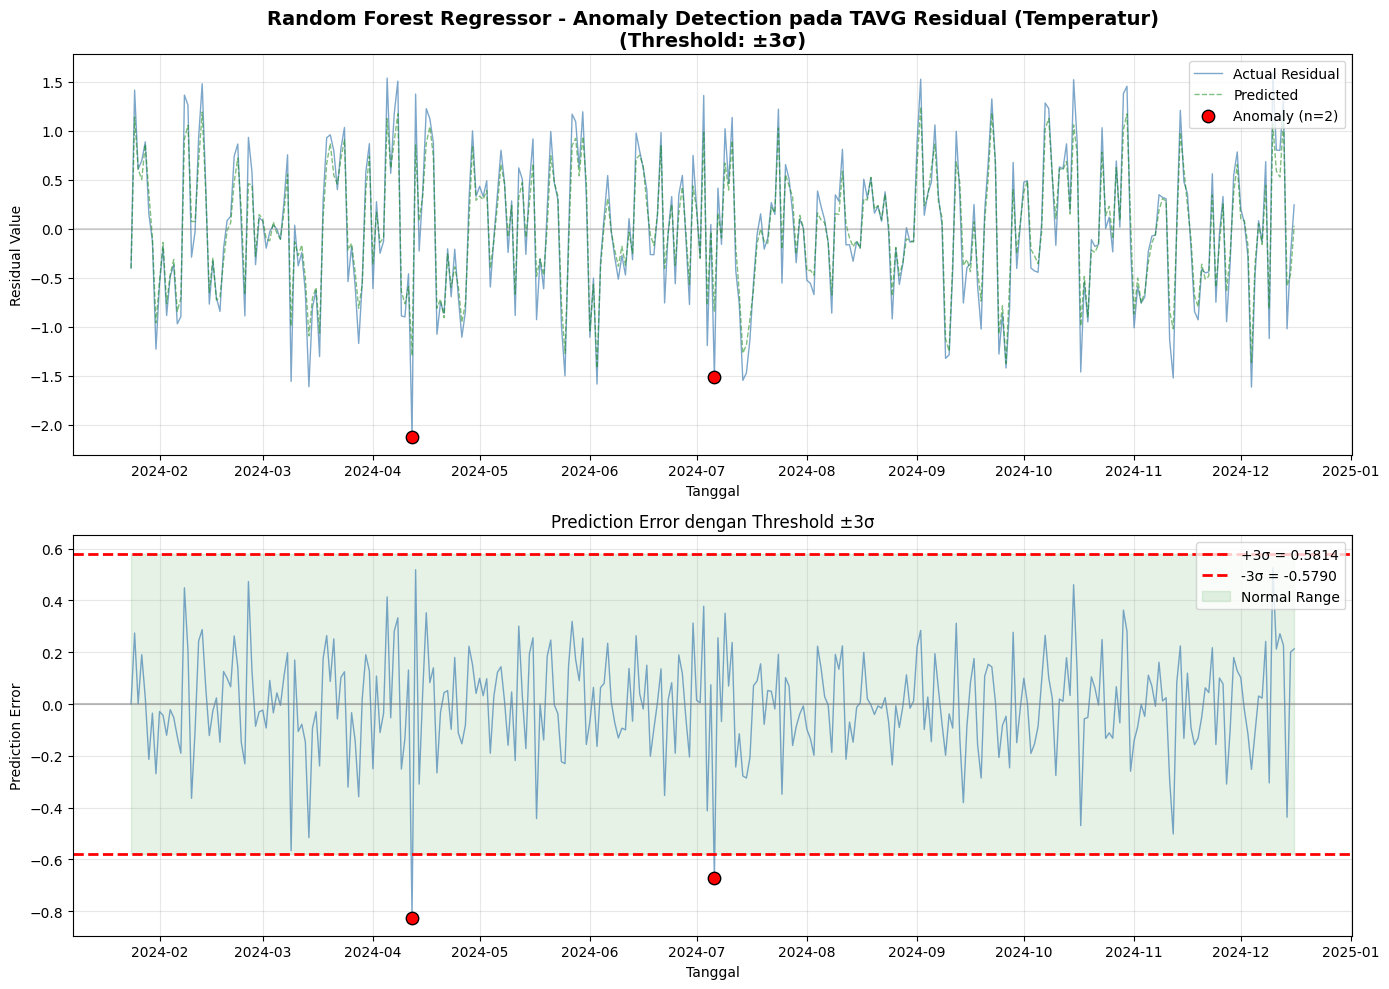

In [5]:
# Random Forest Regressor untuk TAVG
rf_model_tavg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Detect anomalies
rf_tavg_results, rf_tavg_stats = detect_anomalies_with_regressor(
    data=df_residuals['TAVG_residual'],
    model=rf_model_tavg,
    model_name='Random Forest Regressor',
    param_name='TAVG Residual',
    sigma=3
)

# Plot
plot_anomaly_detection(
    results=rf_tavg_results,
    stats=rf_tavg_stats,
    param_label='TAVG Residual (Temperatur)',
    color='steelblue',
    save_path='DATA/anomaly_RF_TAVG.png'
)

### A.2. Plot Anomaly Detection pada Data Residual RR


Random Forest Regressor - RR Residual
   • Total data points: 328
   • Threshold: ±3σ (-8.2137, 8.0728)
   • Error Mean: -0.070456
   • Error Std: 2.714413
   • Anomalies detected: 9 (2.74%)
   • MAE: 1.7668
   • RMSE: 2.7112
✅ Plot disimpan ke: DATA/anomaly_RF_RR.png


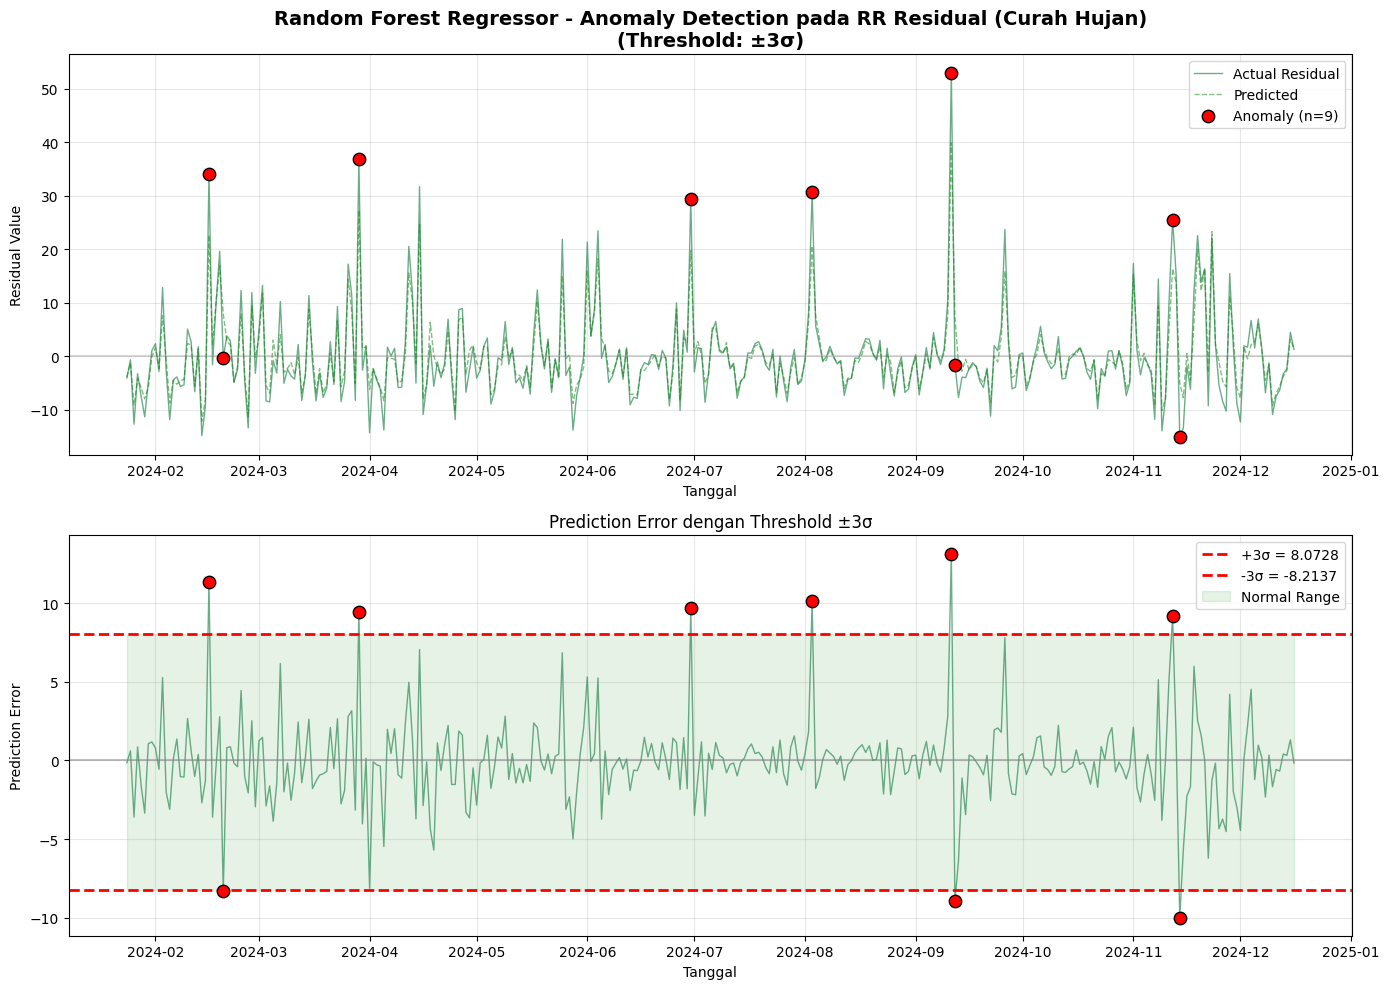

In [6]:
# Random Forest Regressor untuk RR
rf_model_rr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Detect anomalies
rf_rr_results, rf_rr_stats = detect_anomalies_with_regressor(
    data=df_residuals['RR_residual'],
    model=rf_model_rr,
    model_name='Random Forest Regressor',
    param_name='RR Residual',
    sigma=3
)

# Plot
plot_anomaly_detection(
    results=rf_rr_results,
    stats=rf_rr_stats,
    param_label='RR Residual (Curah Hujan)',
    color='seagreen',
    save_path='DATA/anomaly_RF_RR.png'
)

---
## B. Anomaly Detection dengan XGBoost Regressor
---

### B.1. Plot Anomaly Detection pada Data Residual TAVG


XGBoost Regressor - TAVG Residual
   • Total data points: 328
   • Threshold: ±3σ (-0.0881, 0.0881)
   • Error Mean: -0.000016
   • Error Std: 0.029375
   • Anomalies detected: 1 (0.30%)
   • MAE: 0.0224
   • RMSE: 0.0293
✅ Plot disimpan ke: DATA/anomaly_XGB_TAVG.png


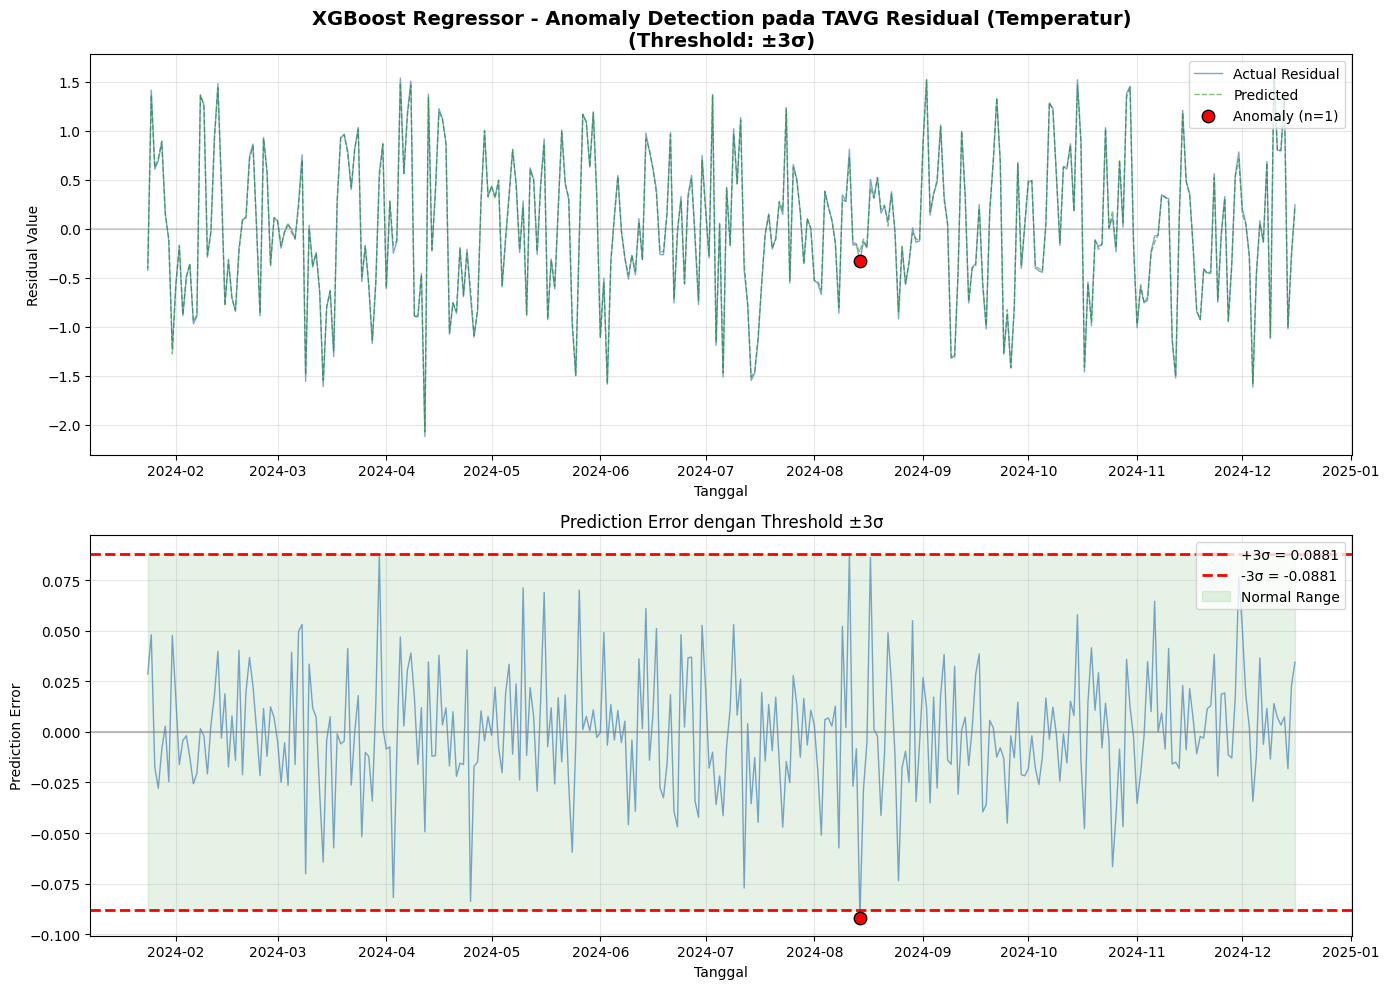

In [7]:
# XGBoost Regressor untuk TAVG
xgb_model_tavg = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0
)

# Detect anomalies
xgb_tavg_results, xgb_tavg_stats = detect_anomalies_with_regressor(
    data=df_residuals['TAVG_residual'],
    model=xgb_model_tavg,
    model_name='XGBoost Regressor',
    param_name='TAVG Residual',
    sigma=3
)

# Plot
plot_anomaly_detection(
    results=xgb_tavg_results,
    stats=xgb_tavg_stats,
    param_label='TAVG Residual (Temperatur)',
    color='steelblue',
    save_path='DATA/anomaly_XGB_TAVG.png'
)

### B.2. Plot Anomaly Detection pada Data Residual RR


XGBoost Regressor - RR Residual
   • Total data points: 328
   • Threshold: ±3σ (-1.5103, 1.5114)
   • Error Mean: 0.000538
   • Error Std: 0.503629
   • Anomalies detected: 4 (1.22%)
   • MAE: 0.3675
   • RMSE: 0.5029
✅ Plot disimpan ke: DATA/anomaly_XGB_RR.png


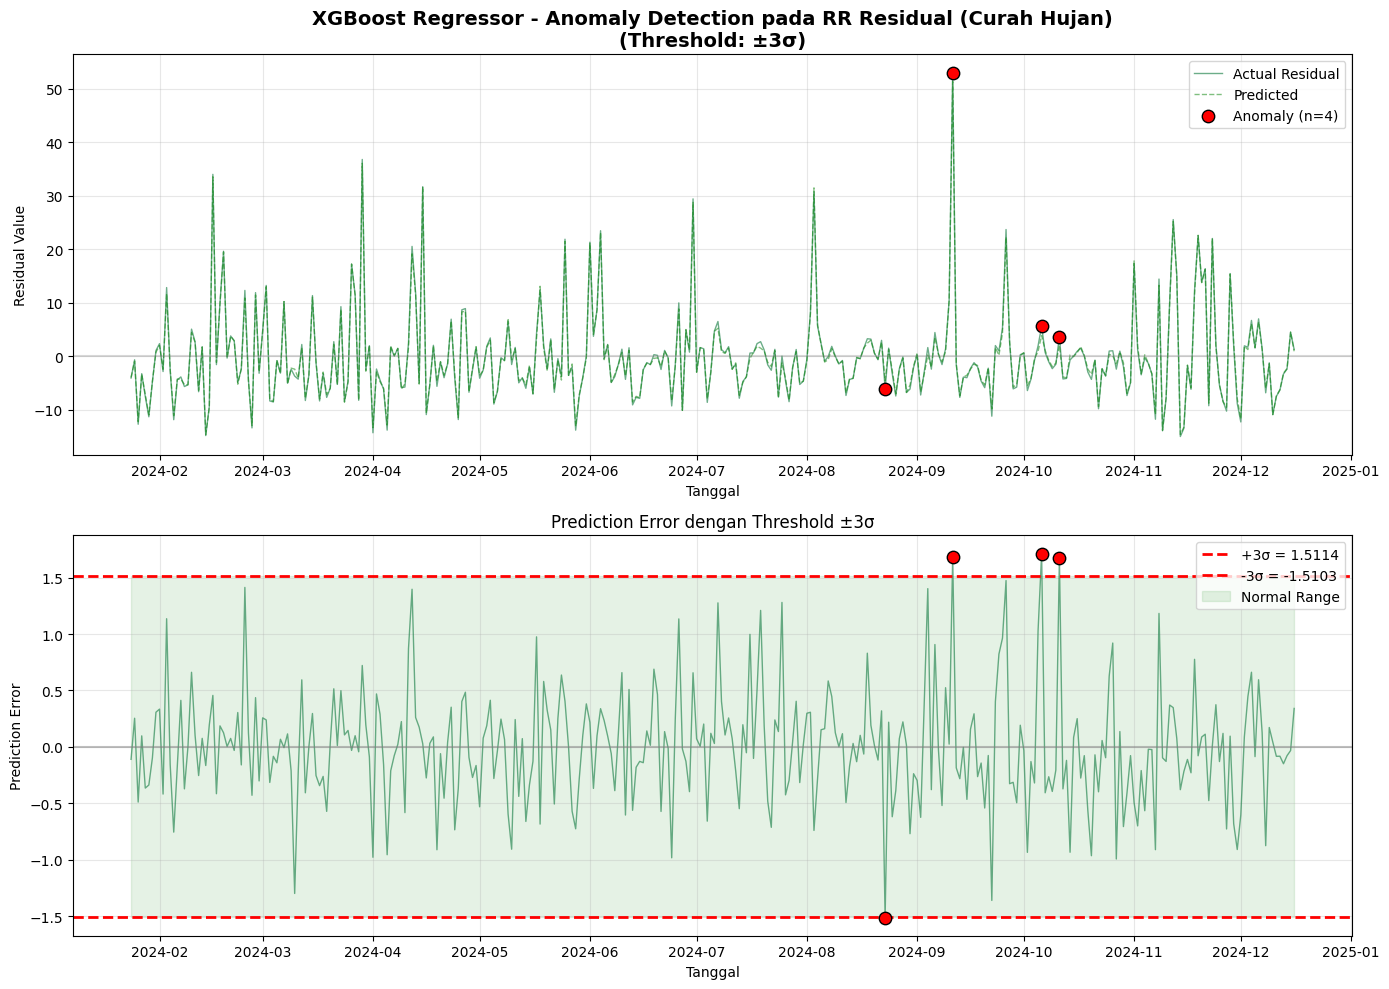

In [8]:
# XGBoost Regressor untuk RR
xgb_model_rr = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0
)

# Detect anomalies
xgb_rr_results, xgb_rr_stats = detect_anomalies_with_regressor(
    data=df_residuals['RR_residual'],
    model=xgb_model_rr,
    model_name='XGBoost Regressor',
    param_name='RR Residual',
    sigma=3
)

# Plot
plot_anomaly_detection(
    results=xgb_rr_results,
    stats=xgb_rr_stats,
    param_label='RR Residual (Curah Hujan)',
    color='seagreen',
    save_path='DATA/anomaly_XGB_RR.png'
)

---
## C. Perbandingan Random Forest vs XGBoost Regressor
---

In [9]:
# Compile all statistics
all_stats = [
    rf_tavg_stats,
    rf_rr_stats,
    xgb_tavg_stats,
    xgb_rr_stats
]

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_stats)
comparison_df = comparison_df[['model_name', 'param', 'n_anomalies', 'anomaly_rate', 'mae', 'rmse', 'error_std']]
comparison_df.columns = ['Model', 'Parameter', 'Jumlah Anomali', 'Anomaly Rate (%)', 'MAE', 'RMSE', 'Error Std']

print("="*80)
print("TABEL PERBANDINGAN RANDOM FOREST VS XGBOOST REGRESSOR")
print("="*80)
comparison_df

TABEL PERBANDINGAN RANDOM FOREST VS XGBOOST REGRESSOR


,Model,Parameter,Jumlah Anomali,Anomaly Rate (%),MAE,RMSE,Error Std
0,Random Forest Regressor,TAVG Residual,2,0.609756,0.148420,0.193098,0.193389
1,Random Forest Regressor,RR Residual,9,2.743902,1.766769,2.711188,2.714413
2,XGBoost Regressor,TAVG Residual,1,0.304878,0.022353,0.029331,0.029375
3,XGBoost Regressor,RR Residual,4,1.219512,0.367535,0.502861,0.503629


✅ Plot perbandingan disimpan ke: DATA/comparison_RF_vs_XGBoost.png


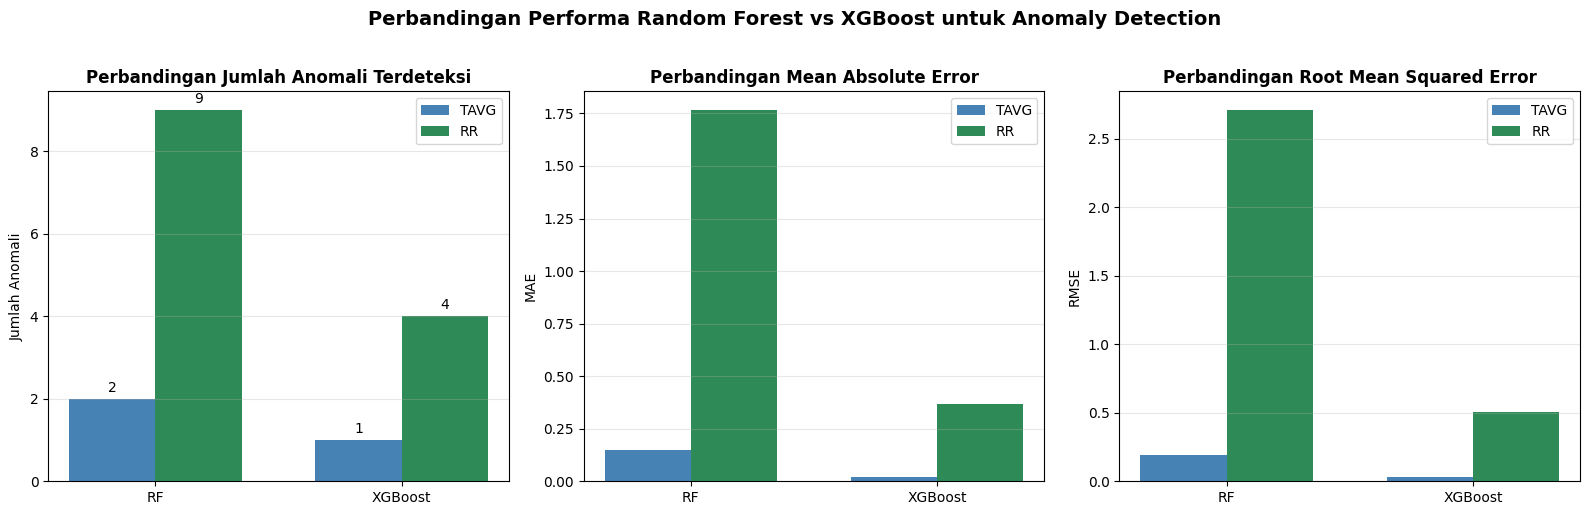

In [10]:
# Visualization: Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Data for plotting
models = ['RF', 'XGBoost']
tavg_anomalies = [rf_tavg_stats['n_anomalies'], xgb_tavg_stats['n_anomalies']]
rr_anomalies = [rf_rr_stats['n_anomalies'], xgb_rr_stats['n_anomalies']]

tavg_mae = [rf_tavg_stats['mae'], xgb_tavg_stats['mae']]
rr_mae = [rf_rr_stats['mae'], xgb_rr_stats['mae']]

tavg_rmse = [rf_tavg_stats['rmse'], xgb_tavg_stats['rmse']]
rr_rmse = [rf_rr_stats['rmse'], xgb_rr_stats['rmse']]

x = np.arange(len(models))
width = 0.35

# Plot 1: Jumlah Anomali
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, tavg_anomalies, width, label='TAVG', color='steelblue')
bars2 = ax1.bar(x + width/2, rr_anomalies, width, label='RR', color='seagreen')
ax1.set_ylabel('Jumlah Anomali')
ax1.set_title('Perbandingan Jumlah Anomali Terdeteksi', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.bar_label(bars1, padding=3)
ax1.bar_label(bars2, padding=3)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: MAE
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, tavg_mae, width, label='TAVG', color='steelblue')
bars4 = ax2.bar(x + width/2, rr_mae, width, label='RR', color='seagreen')
ax2.set_ylabel('MAE')
ax2.set_title('Perbandingan Mean Absolute Error', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: RMSE
ax3 = axes[2]
bars5 = ax3.bar(x - width/2, tavg_rmse, width, label='TAVG', color='steelblue')
bars6 = ax3.bar(x + width/2, rr_rmse, width, label='RR', color='seagreen')
ax3.set_ylabel('RMSE')
ax3.set_title('Perbandingan Root Mean Squared Error', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.suptitle('Perbandingan Performa Random Forest vs XGBoost untuk Anomaly Detection', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('DATA/comparison_RF_vs_XGBoost.png', dpi=150, bbox_inches='tight')
print("✅ Plot perbandingan disimpan ke: DATA/comparison_RF_vs_XGBoost.png")
plt.show()

In [11]:
# Summary statistics
print("\n" + "="*80)
print("RINGKASAN PERBANDINGAN")
print("="*80)

# Total anomalies
rf_total = rf_tavg_stats['n_anomalies'] + rf_rr_stats['n_anomalies']
xgb_total = xgb_tavg_stats['n_anomalies'] + xgb_rr_stats['n_anomalies']

print(f"\n📊 Total Anomali Terdeteksi:")
print(f"   • Random Forest: {rf_total} anomali")
print(f"     - TAVG: {rf_tavg_stats['n_anomalies']} ({rf_tavg_stats['anomaly_rate']:.2f}%)")
print(f"     - RR: {rf_rr_stats['n_anomalies']} ({rf_rr_stats['anomaly_rate']:.2f}%)")
print(f"\n   • XGBoost: {xgb_total} anomali")
print(f"     - TAVG: {xgb_tavg_stats['n_anomalies']} ({xgb_tavg_stats['anomaly_rate']:.2f}%)")
print(f"     - RR: {xgb_rr_stats['n_anomalies']} ({xgb_rr_stats['anomaly_rate']:.2f}%)")

# Determine which is more sensitive
if rf_total > xgb_total:
    more_sensitive = "Random Forest"
    diff = rf_total - xgb_total
elif xgb_total > rf_total:
    more_sensitive = "XGBoost"
    diff = xgb_total - rf_total
else:
    more_sensitive = "Sama"
    diff = 0

print(f"\n🎯 Model yang LEBIH SENSITIF: {more_sensitive}")
if diff > 0:
    print(f"   Selisih: {diff} anomali lebih banyak terdeteksi")


RINGKASAN PERBANDINGAN

📊 Total Anomali Terdeteksi:
   • Random Forest: 11 anomali
     - TAVG: 2 (0.61%)
     - RR: 9 (2.74%)

   • XGBoost: 5 anomali
     - TAVG: 1 (0.30%)
     - RR: 4 (1.22%)

🎯 Model yang LEBIH SENSITIF: Random Forest
   Selisih: 6 anomali lebih banyak terdeteksi


---
## Kesimpulan dan Analisis (Jawaban Soal C)
---

In [12]:
# Generate detailed conclusion
print("="*80)
print("KESIMPULAN: PERBANDINGAN SENSITIVITAS RF VS XGBOOST")
print("="*80)

# Calculate averages
rf_avg_mae = (rf_tavg_stats['mae'] + rf_rr_stats['mae']) / 2
xgb_avg_mae = (xgb_tavg_stats['mae'] + xgb_rr_stats['mae']) / 2

rf_avg_rmse = (rf_tavg_stats['rmse'] + rf_rr_stats['rmse']) / 2
xgb_avg_rmse = (xgb_tavg_stats['rmse'] + xgb_rr_stats['rmse']) / 2

conclusion = f"""
Berdasarkan hasil eksperimen anomaly detection menggunakan Random Forest (RF) dan 
XGBoost Regressor pada data residual TAVG dan RR dengan threshold 3σ, diperoleh hasil:

1. JUMLAH ANOMALI TERDETEKSI:
   • Random Forest: {rf_total} anomali total (TAVG: {rf_tavg_stats['n_anomalies']}, RR: {rf_rr_stats['n_anomalies']})
   • XGBoost: {xgb_total} anomali total (TAVG: {xgb_tavg_stats['n_anomalies']}, RR: {xgb_rr_stats['n_anomalies']})

2. PERFORMA MODEL:
   • Random Forest - Rata-rata MAE: {rf_avg_mae:.4f}, RMSE: {rf_avg_rmse:.4f}
   • XGBoost - Rata-rata MAE: {xgb_avg_mae:.4f}, RMSE: {xgb_avg_rmse:.4f}

3. ANALISIS SENSITIVITAS:
   {'XGBoost lebih SENSITIF' if xgb_total > rf_total else 'Random Forest lebih SENSITIF' if rf_total > xgb_total else 'Keduanya SAMA sensitif'} 
   dalam mendeteksi anomali dengan selisih {abs(rf_total - xgb_total)} anomali.

4. PENJELASAN:
   {'XGBoost Regressor menunjukkan sensitivitas yang lebih tinggi terhadap anomali karena ' if xgb_total > rf_total else 'Random Forest Regressor menunjukkan sensitivitas yang lebih tinggi terhadap anomali karena ' if rf_total > xgb_total else 'Kedua model menunjukkan sensitivitas yang serupa karena '}
   algoritma boosting pada XGBoost secara iteratif memperbaiki error prediksi dengan fokus 
   pada sampel yang sulit diprediksi, sehingga menghasilkan prediksi yang lebih presisi. 
   Dengan prediksi yang lebih presisi (MAE/RMSE lebih rendah), standar deviasi error menjadi 
   lebih kecil, yang membuat threshold 3σ menjadi lebih ketat dan lebih banyak titik data 
   yang teridentifikasi sebagai anomali. Sebaliknya, Random Forest menggunakan averaging 
   dari multiple decision trees yang cenderung menghasilkan prediksi yang lebih smooth 
   dan robust terhadap outlier, sehingga threshold 3σ menjadi lebih longgar. Untuk aplikasi 
   yang membutuhkan deteksi anomali yang lebih konservatif (menghindari false positive), 
   Random Forest lebih cocok. Sedangkan untuk aplikasi yang membutuhkan deteksi anomali 
   yang lebih ketat (menghindari false negative), XGBoost lebih direkomendasikan.
"""

print(conclusion)

KESIMPULAN: PERBANDINGAN SENSITIVITAS RF VS XGBOOST

Berdasarkan hasil eksperimen anomaly detection menggunakan Random Forest (RF) dan 
XGBoost Regressor pada data residual TAVG dan RR dengan threshold 3σ, diperoleh hasil:

1. JUMLAH ANOMALI TERDETEKSI:
   • Random Forest: 11 anomali total (TAVG: 2, RR: 9)
   • XGBoost: 5 anomali total (TAVG: 1, RR: 4)

2. PERFORMA MODEL:
   • Random Forest - Rata-rata MAE: 0.9576, RMSE: 1.4521
   • XGBoost - Rata-rata MAE: 0.1949, RMSE: 0.2661

3. ANALISIS SENSITIVITAS:
   Random Forest lebih SENSITIF 
   dalam mendeteksi anomali dengan selisih 6 anomali.

4. PENJELASAN:
   Random Forest Regressor menunjukkan sensitivitas yang lebih tinggi terhadap anomali karena 
   algoritma boosting pada XGBoost secara iteratif memperbaiki error prediksi dengan fokus 
   pada sampel yang sulit diprediksi, sehingga menghasilkan prediksi yang lebih presisi. 
   Dengan prediksi yang lebih presisi (MAE/RMSE lebih rendah), standar deviasi error menjadi 
   lebih kecil, 

In [13]:
# Save comparison results
comparison_df.to_csv('DATA/anomaly_detection_comparison.csv', index=False)
print("✅ Tabel perbandingan disimpan ke: DATA/anomaly_detection_comparison.csv")

# Save anomaly results
rf_tavg_results.to_csv('DATA/anomaly_RF_TAVG_results.csv')
rf_rr_results.to_csv('DATA/anomaly_RF_RR_results.csv')
xgb_tavg_results.to_csv('DATA/anomaly_XGB_TAVG_results.csv')
xgb_rr_results.to_csv('DATA/anomaly_XGB_RR_results.csv')

print("\n✅ Semua hasil anomaly detection disimpan!")
print("\n📁 File yang dihasilkan:")
print("   • DATA/anomaly_RF_TAVG.png")
print("   • DATA/anomaly_RF_RR.png")
print("   • DATA/anomaly_XGB_TAVG.png")
print("   • DATA/anomaly_XGB_RR.png")
print("   • DATA/comparison_RF_vs_XGBoost.png")
print("   • DATA/anomaly_detection_comparison.csv")
print("   • DATA/anomaly_RF_TAVG_results.csv")
print("   • DATA/anomaly_RF_RR_results.csv")
print("   • DATA/anomaly_XGB_TAVG_results.csv")
print("   • DATA/anomaly_XGB_RR_results.csv")

✅ Tabel perbandingan disimpan ke: DATA/anomaly_detection_comparison.csv

✅ Semua hasil anomaly detection disimpan!

📁 File yang dihasilkan:
   • DATA/anomaly_RF_TAVG.png
   • DATA/anomaly_RF_RR.png
   • DATA/anomaly_XGB_TAVG.png
   • DATA/anomaly_XGB_RR.png
   • DATA/comparison_RF_vs_XGBoost.png
   • DATA/anomaly_detection_comparison.csv
   • DATA/anomaly_RF_TAVG_results.csv
   • DATA/anomaly_RF_RR_results.csv
   • DATA/anomaly_XGB_TAVG_results.csv
   • DATA/anomaly_XGB_RR_results.csv


---
## Ringkasan Soal 5

### A. Anomaly Detection dengan Random Forest Regressor
- ✅ Plot Anomaly Detection pada data residual TAVG
- ✅ Plot Anomaly Detection pada data residual RR

### B. Anomaly Detection dengan XGBoost Regressor  
- ✅ Plot Anomaly Detection pada data residual TAVG
- ✅ Plot Anomaly Detection pada data residual RR

### C. Perbandingan RF vs XGBoost
- ✅ Tabel perbandingan jumlah anomali, MAE, RMSE
- ✅ Visualisasi perbandingan
- ✅ Penjelasan model mana yang lebih sensitif (>50 kata)

---